In [1]:
from __future__ import print_function
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import argparse
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,5)
        self.conv2=nn.Conv2d(10,30,5)
        self.conv3=nn.Conv2d(30,10,5)
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv3(x))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.log_softmax(x,dim=1)
    


In [3]:
def train(model,device,optimizer,train_loader,epoch):
    model.train()
    for batch_idx,(target,data) in enumerate(train_loader):
        data=data.reshape(64,1,28,28)
        #print(target[1])
        #plt.imshow(data[1,:,:,:].reshape(28,28))
        data,target=data.to(device),target.to(device)
        optimizer.zero_grad()
        output=model(data)
        loss=F.nll_loss(data,target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [4]:
def test(model,device,optimizer,test_loader,epoch):
    model.eval()
    testloss=0
    correct=0
    with torch.no_grad():
        for target, data in test_loader:
            #print(target[1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [5]:
class MnistDataSet(Dataset):
    def __init__(self,csv_file,transform=None):
        self.images=pd.read_csv(csv_file)
        self.labels=self.images.iloc[:,0].values
        self.transform=transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        return self.labels[idx],self.images.iloc[idx,1:].values/255

In [6]:
traindata=MnistDataSet('train.csv')
testdata=MnistDataSet('test.csv')
len(traindata)
len(testdata)

28000

In [7]:
label,img=traindata[150]

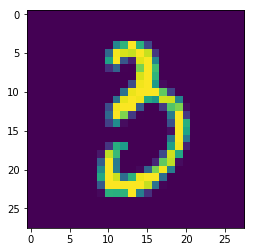

In [8]:
plt.imshow(img.reshape(28,28))

In [9]:
train_loader = torch.utils.data.DataLoader(traindata,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testdata,batch_size=64, shuffle=True)

In [18]:
del(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net().to(device)

torch.cuda.is_available()

True

In [15]:
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [16]:
for epoch in range(1,10):
    train(model,device,optimizer,train_loader,epoch)
    test(model,device,optimizer,test_loader,epoch)

RuntimeError: Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same